<a id="top"></a>
# Water Extents

<hr>

# Notebook Summary

The spatial extents of water in a scene are analyzed with optical (Landsat) and SAR (Sentinel 1) data.

<hr>

# Algorithmic process  

* [Import Dependencies and Connect to the Data Cube](#import)
* [Choose Platform and Product](#plat_prod)
* [Get the Maximum Extents of the Cube](#extents)
* [Define the Extents of the Analysis](#define_extents)
* [Load Data from the Data Cube](#retrieve_data)
    * Load Optical Data (Landsat)
    * Load SAR Data (Sentinel 1)
* [Get Water Classifications](#get_water_cls)
    * Get WOFS Classifications for Landsat Data
    * Get WASARD Classifications for Sentinel 1 Data
    * Combine and Resample Water Classifications
* [Examine the Minimum and Maximum Water Extents](#examine_water_extents)

For more information, visit this website: http://www.ga.gov.au/scientific-topics/hazards/flood/wofs

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span>

In [1]:
# Enable importing of utilities.
import sys
sys.path.append('..')

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import xarray as xr
 
import datacube
from utils.data_cube_utilities.data_access_api import DataAccessApi

In [2]:
api = DataAccessApi()
dc = api.dc

## <span id="plat_prod">Choose Platform and Product [&#9652;](#top)</span>

In [3]:
# Get available products
products_info = dc.list_products()
products_info

,name,description,lon,platform,product_type,time,lat,instrument,creation_time,format,label,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,
2,ls7_usgs_sr_scene,Landsat 7 USGS Collection 1 Level2 Surface Ref...,None,LANDSAT_7,LEDAPS,None,None,ETM,None,GeoTiff,None,EPSG:4326,"(-0.00027777777778, 0.00027777777778)",None,"(latitude, longitude)"
1,ls8_usgs_sr_scene,Landsat 8 USGS Collection 1 Level2 Surface Ref...,None,LANDSAT_8,LaSRC,None,None,OLI_TIRS,None,GeoTiff,None,EPSG:4326,"(-0.00027777777778, 0.00027777777778)",None,"(latitude, longitude)"


In [4]:
# List LANDSAT 7 products (remove comments below to see list of products)
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


,platform,name
id,,
2,LANDSAT_7,ls7_usgs_sr_scene


In [5]:
# List LANDSAT 8 products (remove comments below to see list of products)
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


,platform,name
id,,
1,LANDSAT_8,ls8_usgs_sr_scene


In [6]:
# List Sentinel 1 products (remove comments below to see list of products)
print("Sentinel 1 Products:")
products_info[["platform", "name"]][products_info.platform == "SENTINEL1"]

Sentinel 1 Products:


,platform,name
id,,


<p style="color:red";><b>CHANGE INPUTS BELOW

In [7]:
# These are the optical platforms (satellites) and 
# products (datacube sets) used for this demonstration.
use_Landsat7 = True
use_Landsat8 = True
optical_platforms = []
optical_products = []
if use_Landsat7:
    optical_platforms.append('LANDSAT_7')
    optical_products.append('ls7_usgs_sr_scene')
if use_Landsat8:
    optical_platforms.append('LANDSAT_8')
    optical_products.append('ls8_usgs_sr_scene')

# These are the SAR platforms (satellites) and 
# products (datacube sets) used for this demonstration.
sar_platforms = []
sar_products = []

platforms = optical_platforms + sar_platforms
products = optical_products + sar_products
assert len(platforms) > 0, "There must be at least one platform (and corresponding product) selected."

# The fraction of the original resolution to use for analysis.
# Use this to control memory consumption and run time.
# Set this to None to not scale the resolution of the data.
frac_res = None

## <span id="extents">Get the Maximum Extents of the Cube [&#9652;](#top)</span>

In [8]:
from utils.data_cube_utilities.dc_load import get_overlapping_area
from utils.data_cube_utilities.dc_time import dt_to_str

full_lat, full_lon, min_max_dates = get_overlapping_area(api, platforms, products)

# Print the extents of each product.
str_min_max_dates = np.vectorize(dt_to_str)(min_max_dates)
for i, (platform, product) in enumerate(zip(platforms, products)):
    print("For platform {} and product {}:".format(platform, product))
    print("Time Extents:", str_min_max_dates[i])
    print()

# Print the extents of the combined data.
min_start_date_mutual = np.max(min_max_dates[:,0])
max_end_date_mutual = np.min(min_max_dates[:,1])
print("Overlapping Extents:")
print("Latitude Extents:", full_lat)
print("Longitude Extents:", full_lon)
print("Time Extents:", list(map(dt_to_str, (min_start_date_mutual, max_end_date_mutual))))

For platform LANDSAT_7 and product ls7_usgs_sr_scene:
Time Extents: ['1999-07-08' '2020-01-10']

For platform LANDSAT_8 and product ls8_usgs_sr_scene:
Time Extents: ['2013-03-21' '2020-01-27']

Overlapping Extents:
Latitude Extents: (-12.57305555565614, 18.32305555570214)
Longitude Extents: (-25.47250000020378, 44.01000000035208)
Time Extents: ['2013-03-21', '2020-01-10']


In [9]:
from utils.data_cube_utilities.dc_display_map import display_map

# Display the total shared area available for these datacube products.
display_map(latitude = full_lat,longitude = full_lon)

## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

<p style="color:red";><b>CHANGE INPUTS BELOW

In [10]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# If your datasets are empty, check which products and time extents you used.
# HINT: Keep your region small (<0.5 deg square) to avoid memory overload issues.
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day).
# This region and time period will be used for the water assessment.

# Mombasa, Kenya
# lat = (-4.0475, -3.9574) 
# lon = (39.6028, 39.6792) 
# time_extents = ('2015-01-01', '2018-01-01')

# Ndakaini Dam, Kenya (provides water to Nairobi)
# lat =  (-0.8269, -0.8090)  # full
# lon =  (36.8192, 36.8529) # full
# lat =  (-0.8269, -0.8190)  # small
# lon =  (36.8392, 36.8429) # small
# time_extents = ('2000-01-01', '2018-01-01')

# Lake by Mankessim, Ghana
lat = (5.3010, 5.3240)
lon = (-1.0450, -1.0238)
time_extents = ('2017-01-01', '2017-12-31')

# Lake Sulunga, Tanzania
# latitude_extents = (-6.2622, -5.8822) 
# longitude_extents = (34.9802, 35.3602) 
# time_extents = ('2016-01-01', '2018-01-01')

**Visualize the selected area**

In [11]:
display_map(lat, lon)

## <span id="retrieve_data">Load Data from the Data Cube [&#9652;](#top)</span>

**Load Optical Data (Landsat)**

In [12]:
from utils.data_cube_utilities.dc_load import match_dim_sizes
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask, landsat_clean_mask_invalid
from utils.data_cube_utilities.aggregate import xr_scale_res
from utils.data_cube_utilities.sort import xarray_sortby_coord

matching_abs_res, same_dim_sizes = match_dim_sizes(dc, products, lon, lat, method='min')

optical_datasets = {}
optical_clean_masks = {}
optical_cloud_masks = {}
for platform, product in zip(optical_platforms, optical_products):
    # Load the data.
    # We need the bands ['red', 'green', 'blue', 'nir', 'swir1', 'swir2'] because WOFS uses them.
    # We need the 'pixel_qa' band to mask out undesired pixels.
    measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']
    dataset = dc.load(platform=platform, product=product, 
                      lat=lat, lon=lon, 
                      time=time_extents, measurements=measurements)
    if len(dataset.dims) == 0: # The dataset is empty.
        continue
    # Get the clean masks.
    clean_mask = landsat_qa_clean_mask(dataset, platform) & \
                 (dataset[measurements[0]] != -9999) & \
                 landsat_clean_mask_invalid(dataset)
    cloud_mask = landsat_qa_clean_mask(dataset, platform, cover_types=['cloud'])
    # Remove the 'pixel_qa' band since we have the clean mask.
    dataset = dataset.drop('pixel_qa')
    # If needed, scale the datasets and clean masks to the same size in the x and y dimensions.
    if not same_dim_sizes:
        dataset = xr_scale_res(dataset, abs_res=matching_abs_res)
        clean_mask = xr_scale_res(clean_mask.astype(np.uint8), abs_res=matching_abs_res).astype(np.bool)
        cloud_mask = xr_scale_res(cloud_mask.astype(np.uint8), abs_res=matching_abs_res).astype(np.bool)
    # Clean the data.
    dataset = dataset.astype(np.float32).where(clean_mask)
    optical_datasets[product] = dataset
    optical_clean_masks[product] = clean_mask
    optical_cloud_masks[product] = cloud_mask
# Combine everything.
if len(optical_datasets) > 0:
    optical_dataset = xarray_sortby_coord(xr.concat(list(optical_datasets.values()), dim='time'), coord='time')
    optical_clean_mask = xarray_sortby_coord(xr.concat(list(optical_clean_masks.values()), dim='time'), coord='time')
    optical_cloud_mask = xarray_sortby_coord(xr.concat(list(optical_cloud_masks.values()), dim='time'), coord='time')
else:
    optical_dataset = xr.Dataset()
    optical_clean_mask = xr.DataArray(np.empty((0,), dtype=np.bool))
    optical_cloud_mask = xr.DataArray(np.empty((0,), dtype=np.bool))
del optical_datasets, optical_clean_masks, optical_cloud_masks

In [13]:
optical_dataset

<xarray.Dataset>
Dimensions:    (latitude: 84, longitude: 77, time: 31)
Coordinates:
  * longitude  (longitude) float64 -1.045 -1.045 -1.044 ... -1.024 -1.024 -1.024
  * latitude   (latitude) float64 5.324 5.324 5.323 5.323 ... 5.302 5.301 5.301
  * time       (time) datetime64[ns] 2017-01-08T10:24:05.877035 ... 2017-12-27T10:15:52.569447
Data variables:
    red        (time, latitude, longitude) float32 1014.0 988.0 ... nan nan
    green      (time, latitude, longitude) float32 989.0 1018.0 ... nan nan
    blue       (time, latitude, longitude) float32 945.0 891.0 919.0 ... nan nan
    nir        (time, latitude, longitude) float32 2567.0 2527.0 ... nan nan
    swir1      (time, latitude, longitude) float32 1944.0 1835.0 ... nan nan
    swir2      (time, latitude, longitude) float32 1024.0 947.0 ... nan nan
Attributes:
    crs:      EPSG:4326

**Load SAR Data (Sentinel 1)**

In [14]:
sar_datasets = {}
sar_clean_masks = {}
for platform, product in zip(sar_platforms, sar_products):
    # Load the data.
    measurements = ['vv', 'vh']
    dataset = dc.load(platform=platform, product=product, lat=lat, lon=lon, 
                      time=time_extents, measurements=measurements)
    if len(dataset.dims) == 0: # The dataset is empty.
        continue
    # Get the clean masks.
    clean_mask = (dataset.vv != 0)
    # If needed, scale the datasets and clean masks to the same size in the x and y dimensions.
    if not same_dim_sizes:    
        dataset = xr_scale_res(dataset, abs_res=matching_abs_res)
        clean_mask = xr_scale_res(clean_mask.astype(np.uint8), abs_res=matching_abs_res).astype(np.bool)
    sar_datasets[product], sar_clean_masks[product] = dataset, clean_mask
# Combine everything.
if len(sar_datasets) > 0:
    sar_dataset = xarray_sortby_coord(xr.concat(list(sar_datasets.values()), dim='time'), coord='time')
    sar_clean_mask = xarray_sortby_coord(xr.concat(list(sar_clean_masks.values()), dim='time'), coord='time')
else:
    sar_dataset = xr.Dataset()
    sar_clean_mask = xr.DataArray(np.empty((0,), dtype=np.bool))
del sar_datasets, sar_clean_masks

In [15]:
from utils.data_cube_utilities.dc_load import is_dataset_empty

optical_dataset_is_empty = is_dataset_empty(optical_dataset)
sar_dataset_is_empty = is_dataset_empty(sar_dataset)
# Make coordinates other than time the same between the optical and SAR datasets.
if not optical_dataset_is_empty and not sar_dataset_is_empty:
    sar_dataset.latitude.values = optical_dataset.latitude.values
    sar_dataset.longitude.values = optical_dataset.longitude.values

## <span id="get_water_cls">Get Water Classifications [&#9652;](#top)</span>

**Get WOFS Classifications for Landsat Data**

In [17]:
if not optical_dataset_is_empty:
    from utils.data_cube_utilities.dc_water_classifier import wofs_classify
    optical_dataset['water'] = wofs_classify(optical_dataset, optical_clean_mask.values).wofs.astype(np.float16)
    optical_dataset['water'] = optical_dataset['water'].where(optical_clean_mask & (optical_dataset['water'] != -10000))

**Get WASARD Classifications for Sentinel 1 Data**

In [18]:
if not sar_dataset_is_empty:
    from utils.data_cube_utilities.wasard import wasard_classifier
    wasard_cls = wasard_classifier('wasard/general.pkl')
    sar_dataset['water'] = wasard_cls.wasard_classify(sar_dataset).wasard

**Combine and Resample Water Classifications**

In [19]:
water_datasets = []
if not optical_dataset_is_empty:
    water_datasets.append(optical_dataset.water)
if not sar_dataset_is_empty:
    water_datasets.append(sar_dataset.water)
water = xarray_sortby_coord(xr.concat(water_datasets, dim='time'), coord='time')

In [20]:
# Water classifiers can sometimes output erroneous classifications, so we take a rounded mean 
# of water classifications along time for windows of times to have a more reliable output.
# Must be a number followed by a letter. The number is the number of time periods
# for each composite. The letter is the unit of time and can be one of ['D', 'W', 'M', 'Y'],
# which are days, weeks, months, and years, respectively.
# Set this to None to use all original water classification time slices.
composite_period = None

water = water.resample(time=composite_period).mean('time').round() if composite_period is not None else water

## <span id="examine_water_extents">Examine the Minimum and Maximum Water Extents [&#9652;](#top)</span>

<p style="color:red";><b>CHANGE INPUTS BELOW

In [21]:
## Plot Formatting Settings ##

# Formatting for full-width plots.
title_fontdict = dict(fontsize=16) # Title formatting
tick_label_fmt_dict = dict(axis='both', labelsize=12) # Tick label formatting
axis_label_fmt_dict = dict(fontsize=16) # Axis label formatting
legend_kwargs = dict(fontsize=12)

std_dpi = 200 # Standard image dpi.

## End Plot Formatting Settings ##

**Obtain the minimum and maximum water extents.**

<p style="color:red";><b>CHANGE INPUTS BELOW

In [22]:
## Settings ##

# Can be any of ['time-slice', 'per-pixel'].
# The value 'time-slice' obtains the minimum and maximum water extents on an time-slice basis.
# The value 'per-pixel' obtains the minumum and maximum water extents on a per-pixel basis.
water_extent_method = 'time-slice'
assert water_extent_method in ['time-slice', 'per-pixel'], \
    "The setting `water_extent_method` must be one of ['time-slice', 'per-pixel']."

# This setting is only relevant if `water_extent_method` is set to 'time-slice'.
# Water classifiers can sometimes output erroneous classifications and sometimes excessive clouds
# make compositing an impractical solution to accounting for noisy classifications. 
# And SAR data is sometimes unavailable for WASARD water classification over cloudy regions,
# so percentiles can be specified for the minimum and maximum time slices. These can be between
# 0 and 100. The minimum water time-slice selected will be the time slice with non-water extents
# at or below `percentile_min`. The maximum water time-slice selected will be the time slice 
# with water extents at or below `percentile_max`.
percentile_min, percentile_max = 95, 90

## End Settings ##

# Option 1: Obtain the acquisitions with the minimum and maximum water extents.
if water_extent_method == 'time-slice':
    count_non_water = water.where(water == 0).count(dim=['latitude', 'longitude'])
    count_water = water.where(water == 1).count(dim=['latitude', 'longitude'])
    
    # Find the acquisition with the least water (the one with the most non-water pixels).
    percentile_value_min = np.percentile(count_non_water, percentile_min, interpolation='lower')
    # Handle the case of multiple acquisitions with the same amount of non-water (notably 0).
    acqs_with_value_min = count_non_water == percentile_value_min
    if acqs_with_value_min.sum() > 1: # Find the acquisition with the least water (and most non-water).
        min_extent_time_ind = np.argmin(count_water.isel(time=acqs_with_value_min).values)
    else:
        min_extent_time_ind = (count_non_water == percentile_value_min).argmax().values
    min_extent_time = water.time.values[min_extent_time_ind]
    min_water_extent = water.isel(time=min_extent_time_ind)

    # Find the acquisition with the most water (the one with the most water pixels).
    percentile_value_max = np.percentile(count_water, percentile_max, interpolation='lower')
    # Handle the case of multiple acquisitions with the same amount of water (notably 0).
    acqs_with_value_max = count_water == percentile_value_max
    if acqs_with_value_max.sum() > 1: # Find the acquisition with the least non-water (and most water).
        max_extent_time_ind = np.argmin(count_non_water.isel(time=acqs_with_value_max).values)
    else:
        max_extent_time_ind = (count_water == percentile_value_max).argmax().values
    max_extent_time = water.time.values[max_extent_time_ind]
    max_water_extent = water.isel(time=max_extent_time_ind)
    
# Option 2: Obtain the minimum and maximum water extents on a per-pixel basis.
else: 
    min_water_extent = water.min('time')
    max_water_extent = water.max('time')

**Show the minimum and maximum water extents.**

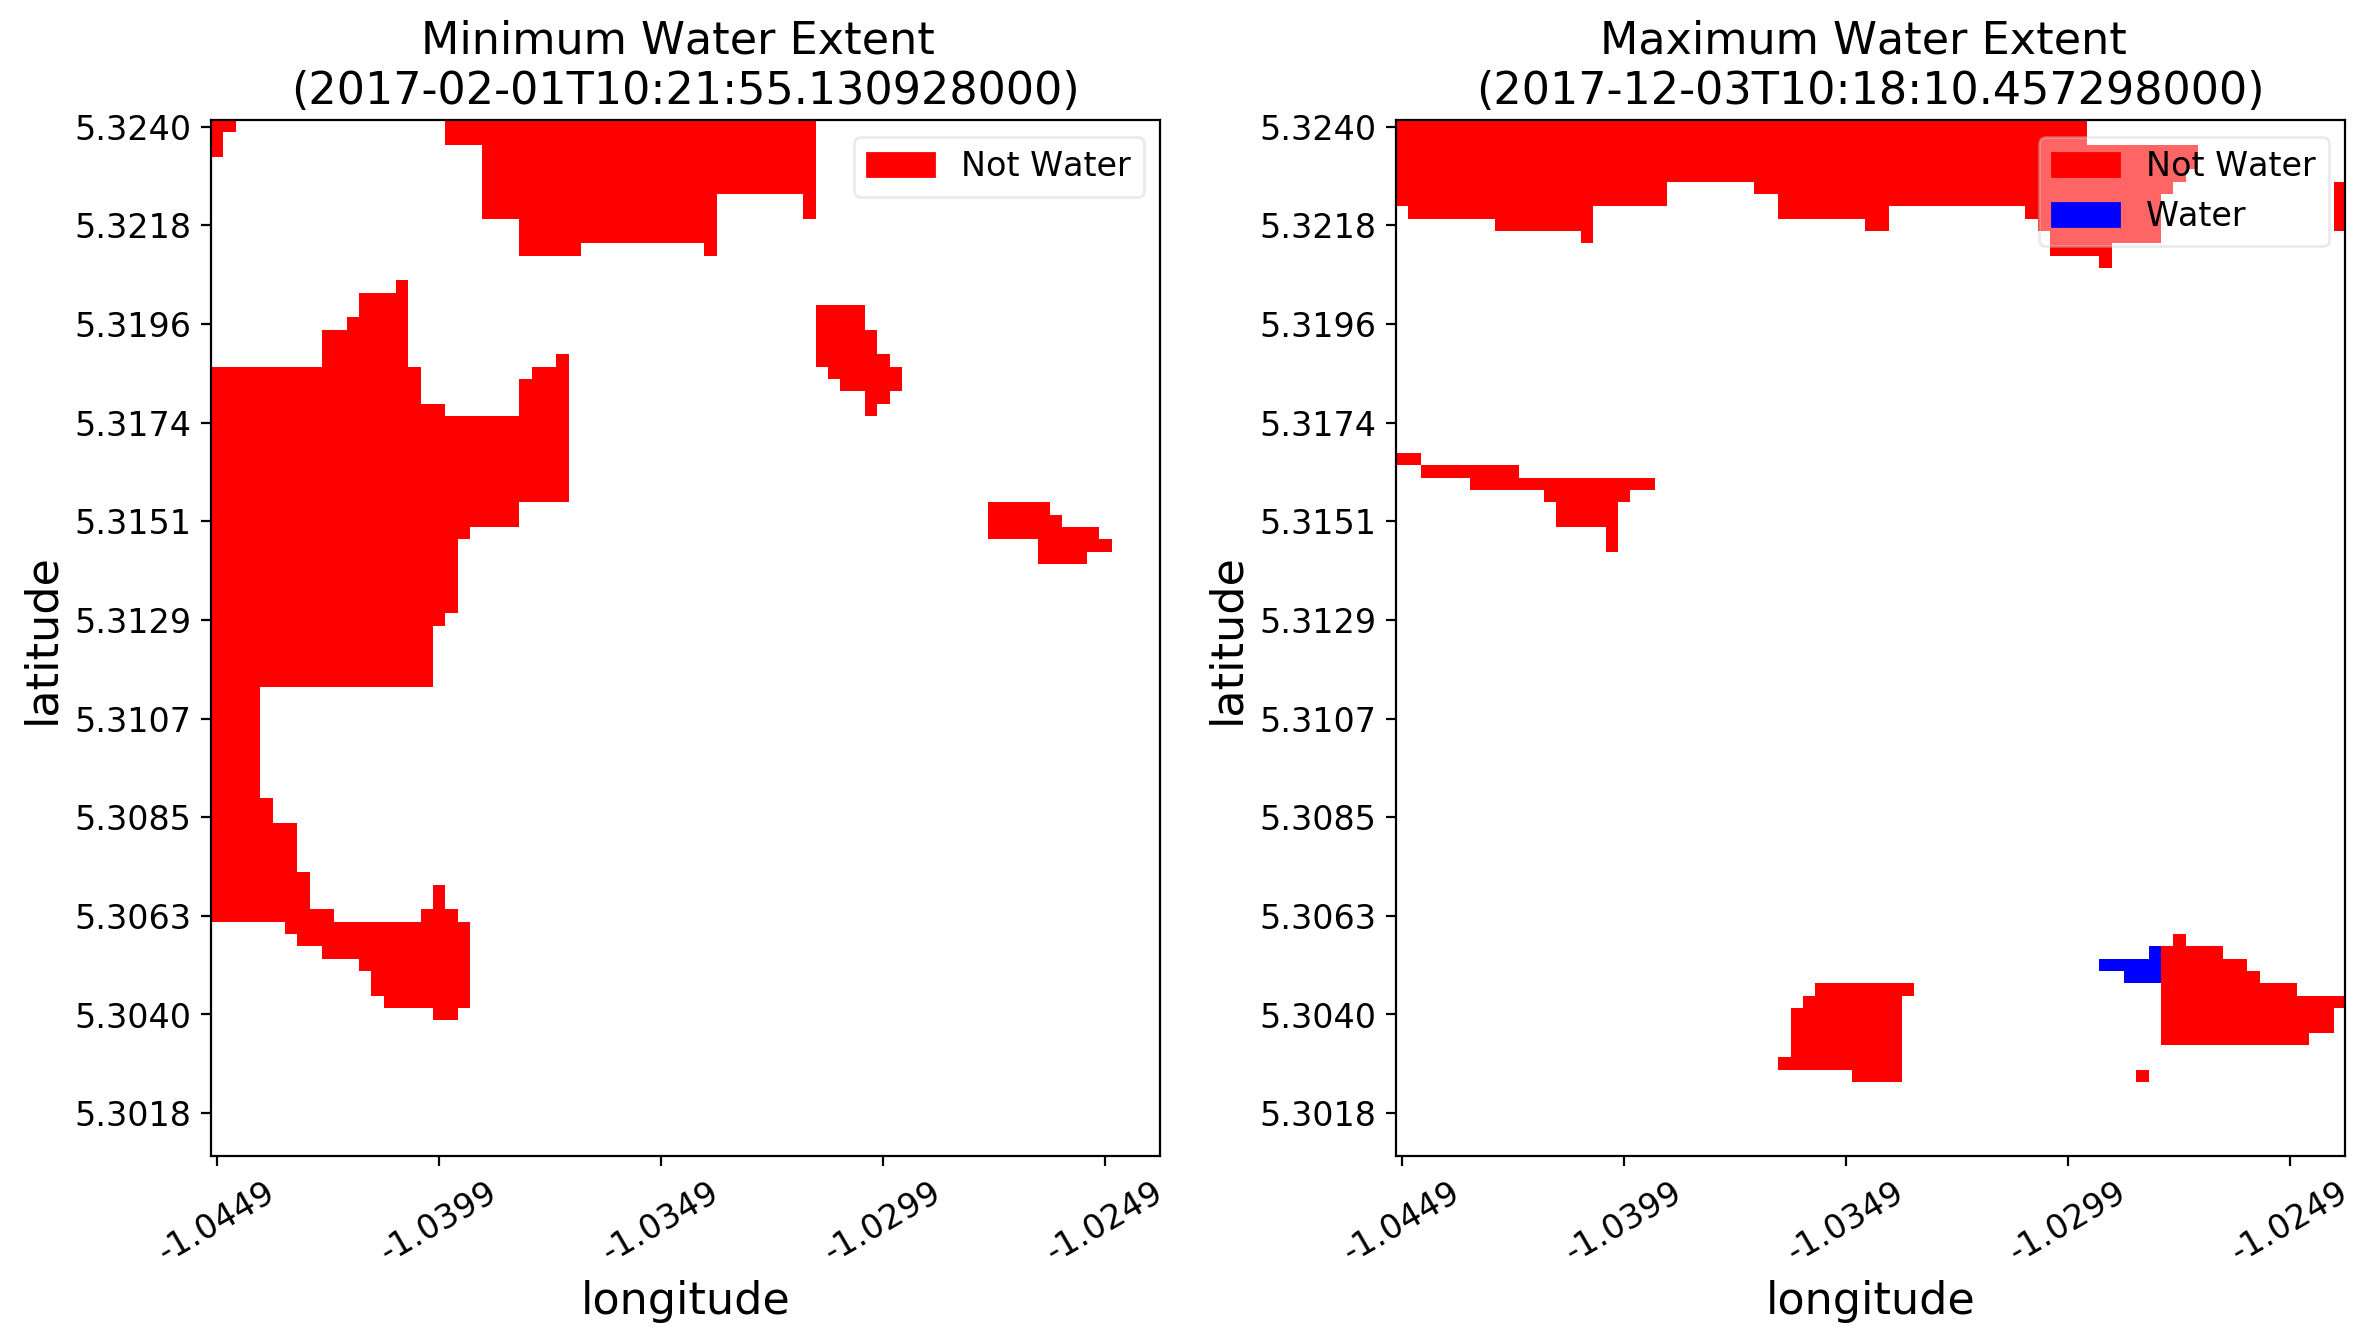

In [23]:
from utils.data_cube_utilities.plotter_utils import figure_ratio, create_discrete_color_map, xarray_imshow

# Begin plotting the data
fig_width = 12 # Use this to change the size of this figure.
fig = plt.figure(figsize=figure_ratio(water, fixed_width=fig_width), dpi=std_dpi)

# Create common colormap.
cmap = create_discrete_color_map([0,1], ['red', 'blue'])

imshow_kwargs = dict(vmin=0, vmax=1, cmap=cmap)

legend_labels = {0:'Not Water', 1:'Water'}

# Minimum water extent
ax = plt.subplot(1,2,1)
fig, ax, im, cbar = \
    xarray_imshow(min_water_extent.astype(np.float32), fig=fig, ax=ax, use_colorbar=False, use_legend=True, 
                  legend_labels=legend_labels, imshow_kwargs=imshow_kwargs, 
                  x_label_kwargs=axis_label_fmt_dict, y_label_kwargs=axis_label_fmt_dict,
                  legend_kwargs=legend_kwargs)
ax.set_title("Minimum Water Extent \n({})".format(min_extent_time), fontdict=title_fontdict)
ax.tick_params(**tick_label_fmt_dict)

# Maximum water extent
ax = plt.subplot(1,2,2)
fig, ax, im, cbar = \
    xarray_imshow(max_water_extent.astype(np.float32), fig=fig, ax=ax, use_colorbar=False, use_legend=True, 
                  legend_labels=legend_labels, imshow_kwargs=imshow_kwargs,
                  x_label_kwargs=axis_label_fmt_dict, y_label_kwargs=axis_label_fmt_dict,
                  legend_kwargs=legend_kwargs)
ax.set_title("Maximum Water Extent \n({})".format(max_extent_time), fontdict=title_fontdict)
ax.tick_params(**tick_label_fmt_dict)

plt.tight_layout()
plt.show()

**For the minimum and maximum water extents, print the percents of pixels that are water, not water, or cloud.**

In [24]:
# Determine the percent of water and non-water pixels for the minimum extent.
num_water_min = (min_water_extent == 1).sum().values
pct_water_min = num_water_min / min_water_extent.size
num_non_water_min = (min_water_extent == 0).sum().values
pct_non_water_min = num_non_water_min / min_water_extent.size

# Determine the percent of water and non-water pixels for the maximum extent.
num_water_max = (max_water_extent == 1).sum().values
pct_water_max = num_water_max / max_water_extent.size
num_non_water_max = (max_water_extent == 0).sum().values
pct_non_water_max = num_non_water_max / max_water_extent.size

# Determine the fraction of cloud pixels for the minium and maximum extents.
if optical_dataset_is_empty: # SAR data is largely unaffected by clouds.
    num_cloud_min, pct_cloud_min, num_cloud_max, pct_cloud_max = [0]*4
else: # Handle time-slice-based extents.
    if water_extent_method == 'time-slice':
        min_acq_is_optical = np.any(optical_cloud_mask.time.values == min_extent_time)
        num_cloud_min = optical_cloud_mask.sel(time=min_extent_time).sum().values \
                        if min_acq_is_optical else 0
        pct_cloud_min = num_cloud_min / min_water_extent.size

        max_acq_is_optical = np.any(optical_cloud_mask.time.values == max_extent_time)
        num_cloud_max = optical_cloud_mask.sel(time=max_extent_time).sum().values \
                        if max_acq_is_optical else 0
        pct_cloud_max = num_cloud_max / max_water_extent.size
    else: # Handle per-pixel extents.
        cloud_masks = []
        if not optical_dataset_is_empty:
            cloud_masks.append(~optical_cloud_mask)
        if not sar_dataset_is_empty:
            cloud_masks.append(sar_clean_mask)
        combined_cloud_mask = xr.concat(cloud_masks, dim='time')
        num_cloud_min = (~combined_cloud_mask).min('time').sum().values
        pct_cloud_min = num_cloud_min / min_water_extent.size
        # For both min and max extents, cloud pixels will be minimized because cloud pixels are masked to NaN,
        # which is ignored (avoided) by the min and max operations for xarrays.
        num_cloud_max = num_cloud_min 
        pct_cloud_max = num_cloud_max / max_water_extent.size

# Determine the percent of no_data values for hte minimum and maximum extents.
num_nodata_min = int(min_water_extent.size - sum([num_water_min, num_non_water_min, num_cloud_min]))
pct_nodata_min = num_nodata_min / min_water_extent.size
num_nodata_max = int(max_water_extent.size - sum([num_water_max, num_non_water_max, num_cloud_max]))
pct_nodata_max = num_nodata_max / max_water_extent.size

print("""The minimum water extent image is composed of the following classes:
    Water ({} pixels - {:.2%} of all pixels)
    Not Water ({} pixels - {:.2%} of all pixels)
    Cloud ({} pixels - {:.2%} of all pixels)
    No-data ({} pixels - {:.2%} of all pixels)"""
    .format(num_water_min, pct_water_min, 
            num_non_water_min, pct_non_water_min, 
            num_cloud_min, pct_cloud_min,
            num_nodata_min, pct_nodata_min))
print()
print("""The maximum water extent image is composed of the following classes:
    Water ({} pixels - {:.2%} of all pixels)
    Not Water ({} pixels - {:.2%} of all pixels),
    Cloud ({} pixels - {:.2%} of all pixels)
    No-data ({} pixels - {:.2%} of all pixels)"""
    .format(num_water_max, pct_water_max, 
            num_non_water_max, pct_non_water_max, 
            num_cloud_max, pct_cloud_max,
            num_nodata_max, pct_nodata_max))

The minimum water extent image is composed of the following classes:
    Water (0 pixels - 0.00% of all pixels)
    Not Water (1130 pixels - 17.47% of all pixels)
    Cloud (2193 pixels - 33.91% of all pixels)
    No-data (3145 pixels - 48.62% of all pixels)

The maximum water extent image is composed of the following classes:
    Water (9 pixels - 0.14% of all pixels)
    Not Water (688 pixels - 10.64% of all pixels),
    Cloud (2736 pixels - 42.30% of all pixels)
    No-data (3035 pixels - 46.92% of all pixels)
